In [5]:
import numpy as np
import cvxpy as cvx
import control as ctrl
import scipy.linalg as linalg
import matplotlib.pyplot as plt 
from tqdm import tqdm

from fct.algorithms import GradientDescent, Nesterov, TMM
from fct.iqc import SectorIQC, OffByOneIQC
from fct.consistent_polytope import ConsistentPolytope
from fct.solver import PolynomialLyapunovMatrix
from fct.lure import LureSystem

In [6]:
def bisection(algorithm, delta_model, rho_max, consistent_polytope, eps=1e-6):

    soll = (np.nan, np.nan, np.nan, np.nan, np.nan)

    ### setup IQCs
    if delta_model:
        IQCs = [SectorIQC(delta_model=delta_model), OffByOneIQC(delta_model=delta_model)]
    else: 
        IQCs = [SectorIQC(delta_model=delta_model)]

    ### setup Lur'e system
    lure = LureSystem(algorithm, IQCs)

    n_eta = lure.n_eta # dimension of extended state
    n_g   = lure.n_g   # dimension of input (g + delta)
    n_z   = lure.n_z    # dimension of output

    ### setup Lyapunov matrix
    lyap = PolynomialLyapunovMatrix(param_dim=1, poly_degree=2, n_eta=n_eta)


    ### start bisection ###
    rho_min = 0
    rho_tol = 1e-3

    while (rho_max-rho_min > rho_tol):

        rho = (rho_min + rho_max)/2

        ### SDP variables ###
        LMI_system = list()
        gamm   = cvx.Variable(1, nonneg=True) if delta_model else 0
        t      = cvx.Variable(1, nonneg=True)

        I_n_eta = np.eye(n_eta)
        t_I    = cvx.multiply(t, I_n_eta)

        ### grid over parameter space ###
        for p_k, delta_p in consistent_polytope:

            p_kp1 = p_k + delta_p

            P_k   = lyap.P(p_k)
            P_kp1 = lyap.P(p_kp1)

            ### update sector constants m(p), L(p)
            m = 1
            L = p_k[0]
            
            ### get extended system and IQC multiplier
            A, B, C, D     = lure.interconnect(m, L, rho)
            iqc_multiplier = lure.build_IQC_multiplier()

            ### setup LMI
            if delta_model:
                # get delta dimension
                n_delt = algorithm.internal_state_dim

                LMI_inner = cvx.bmat([
                    [-rho**2 * P_k, np.zeros((n_eta, n_eta)), np.zeros((n_eta, n_z)), np.zeros((n_eta, n_delt))],
                    [np.zeros((n_eta, n_eta)), P_kp1, np.zeros((n_eta, n_z)), np.zeros((n_eta, n_delt))],
                    [np.zeros((n_z, n_eta)), np.zeros((n_z, n_eta)), iqc_multiplier, np.zeros((n_z, n_delt))], 
                    [np.zeros((n_delt, n_eta)), np.zeros((n_delt, n_eta)), np.zeros((n_delt, n_z)), -cvx.multiply(gamm, np.eye(n_delt))]
                ])

                LMI_outer = cvx.bmat([
                    [I_n_eta, np.zeros((n_eta, n_g))],
                    [cvx.bmat([[A, B]])],
                    [cvx.bmat([[C, D]])],
                    [np.zeros((n_delt, n_eta + n_g - n_delt)), np.eye(n_delt)]
                ])

            else:
                LMI_inner = cvx.bmat([
                    [-rho**2 * P_k, np.zeros((n_eta, n_eta)), np.zeros((n_eta, n_z))],
                    [np.zeros((n_eta, n_eta)), P_kp1, np.zeros((n_eta, n_z))],
                    [np.zeros((n_z, n_eta)), np.zeros((n_z, n_eta)), iqc_multiplier]
                ])

                LMI_outer = cvx.bmat([
                    [I_n_eta, np.zeros((n_eta, n_g))],
                    [cvx.bmat([[A, B]])],
                    [cvx.bmat([[C, D]])]
                ])

            # constraint: LMI <= 0 
            LMI = LMI_outer.T @ LMI_inner @ LMI_outer
            LMI_system.append(LMI << 0)

            # constraint: P(p) > 0
            LMI_system.append(P_k   >> eps*I_n_eta)
            LMI_system.append(P_kp1 >> eps*I_n_eta)

            # constraint: P(p) <= t*I
            LMI_system.append(P_k   << t_I)
            LMI_system.append(P_kp1 << t_I)

            # constraint: 1/t*I <= P(p) (Convexified via Schur complement)
            LMI_system.append(cvx.bmat([[P_k,   I_n_eta],[I_n_eta, t_I]]) >> 0)
            LMI_system.append(cvx.bmat([[P_kp1, I_n_eta],[I_n_eta, t_I]]) >> 0)

        ### solve problem
        problem = cvx.Problem(cvx.Minimize(t + 1e-3*gamm), LMI_system)

        try:
            problem.solve(solver=cvx.MOSEK)
        except(cvx.SolverError):
            pass
    
        if problem.status == cvx.OPTIMAL:
            rho_max = rho
            sol = (lyap.min_max_eigval(list(zip(*consistent_polytope))[0]), gamm, t.value) #TODO: give out lambda value
        else:
            rho_min = rho

        ### reset cvx variables
        lyap.cvx_reset()
        for iqc in IQCs:
            iqc.cvx_reset()
     
    return rho_max, sol

    

In [9]:
kappa_range = np.logspace(np.log10(1/0.8 + 1e-3), 2, 8)

rhos_fast, rhos_middle, rhos_slow, rho_nom = (list() for _ in range(4))

n_sparse = 4

delta_model = True

### select algorithm
algorithm = GradientDescent(nx=1, delta_model=delta_model)
# algorithm = Nesterov(nx=1, delta_model=delta_model)
# algorithm = TMM(nx=1)


for kappa in tqdm(kappa_range):

    ### Create consistent polytope grid over parameters
    kappa_min, kappa_max = kappa * 0.8, kappa
    grid_step = (kappa_max - kappa_min) / n_sparse

    params = np.linspace(kappa_min, kappa_max, n_sparse + 1)
    delta_kappa_max = lambda rate_bound: rate_bound * (kappa_max - kappa_min)

    grid_points_fast = ConsistentPolytope(params, -delta_kappa_max(rate_bound=1), delta_kappa_max(rate_bound=1), step_size=grid_step)
    grid_points_mod  = ConsistentPolytope(params, -delta_kappa_max(rate_bound=0.5), delta_kappa_max(rate_bound=0.5), step_size=grid_step)
    grid_points_slow = ConsistentPolytope(params, -delta_kappa_max(rate_bound=0.05), delta_kappa_max(rate_bound=0.05), step_size=grid_step)
    grid_static = [(np.array([kappa]), np.array([0]))]


    rho, _ = bisection(algorithm=algorithm,
                        delta_model=delta_model,
                        rho_max=1.5, 
                        consistent_polytope=grid_points_fast,
                        eps=1e-6)
    rhos_fast.append(rho)

    rho, sol = bisection(algorithm=algorithm,
                        delta_model=delta_model,
                        rho_max=1.5, 
                        consistent_polytope=grid_points_mod,
                        eps=1e-6)
    rhos_middle.append(rho)


    rho, _ = bisection(algorithm=algorithm,
                        delta_model=delta_model,
                        rho_max=1.5, 
                        consistent_polytope=grid_points_slow,
                        eps=1e-6)
    rhos_slow.append(rho)

    rho, _ = bisection(algorithm=algorithm,
                        delta_model=delta_model,
                        rho_max=1.5, 
                        consistent_polytope=grid_static,
                        eps=1e-6)
    rho_nom.append(rho)


  0%|          | 0/8 [00:00<?, ?it/s]


AssertionError: 

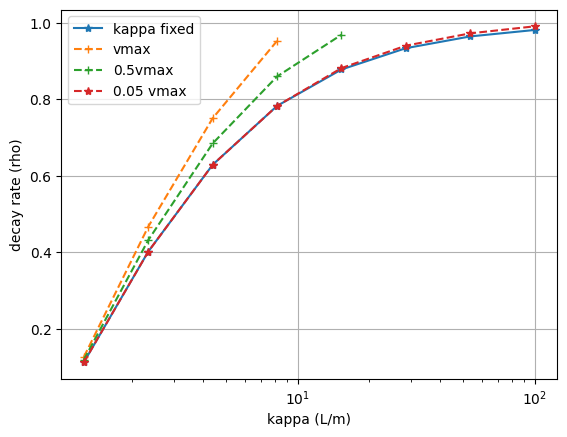

In [8]:
kappa_range, rho_nom, rhos_fast, rhos_middle, rhos_slow = map(np.array, [kappa_range, rho_nom, rhos_fast, rhos_middle, rhos_slow])

plt.semilogx(kappa_range[rho_nom <= 1], rho_nom[rho_nom <= 1], '-*', label='kappa fixed')
plt.semilogx(kappa_range[rhos_fast <= 1], rhos_fast[rhos_fast <= 1], '--+', label='vmax')
plt.semilogx(kappa_range[rhos_middle <= 1], rhos_middle[rhos_middle <= 1], '--+', label='0.5vmax')
plt.semilogx(kappa_range[rhos_slow <= 1], rhos_slow[rhos_slow <= 1], '--*', label='0.05 vmax')

plt.xlabel('kappa (L/m)')
plt.ylabel('decay rate (rho)')
plt.legend()
plt.grid()
plt.show()